In [5]:
#load in packages
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import warnings
dpdcalls = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefilelatlong/dpdshapefilelatlong.shp')
dpdcalls = dpdcalls.loc[~(dpdcalls["X"] == 0) & ~(dpdcalls["Y"] == 0)].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Source"] != "Self Initiated"].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Cancelled"] == 0].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Beat"] != "DSO") & (dpdcalls["Beat"] != "SSA")].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Nature"] != "HANG UP"].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls = dpdcalls[dpdcalls['Priority'].isin(twotosix)].copy()
dpdcalls
pd.set_option("display.max_columns", 100,"display.max_rows",100)

In [86]:
callsperaddress = dpdcalls.groupby( ["Address"] ).size().to_frame(name = 'dpdcalls_count').reset_index()
callsperaddress.sort_values(by='dpdcalls_count', inplace=True, ascending=False)
callsperaddress

,Address,dpdcalls_count
3679,200 S MANGUM ST,892
5779,3400 HILLSBOROUGH RD,826
5967,3600 N ROXBORO ST,808
7619,5400 NEW HOPE COMMONS DR,608
8173,6900 FAYETTEVILLE RD,585
...,...,...
6921,4700 DENFIELD ST,1
6920,4700 DANUBE LN,1
6917,4700 CORAL DR,1
6916,4700 CHICOPEE TRL,1


In [6]:
ncblockmap = gpd.read_file('/Users/erikrobertsson/Downloads/Northcarolinablocksshapefiles/tl_2021_37_tabblock20.shp')
ncblockmap = ncblockmap.to_crs("EPSG:4326")
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [7]:
policebeats = gpd.read_file('/Users/erikrobertsson/Desktop/Police_Beats/Police_Beats.shp')
policebeats = policebeats.to_crs("4326")
policebeats = policebeats.dissolve(by="LAWBEAT")
policebeats["Beat"] = policebeats.index
policebeats = policebeats.reset_index()
policebeats["id"] = policebeats.index
policebeats.head()

,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,Beat,id
0,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0
1,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1
2,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2
3,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3
4,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4


In [8]:
hispanicdata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/hispanic data/hispanicdata.csv', skiprows =1)
hispanicdata['GEOID20'] = hispanicdata['id'].str[-15:]
hispanicdata.drop('id', axis=1, inplace=True)
hispanicdata.drop(hispanicdata.iloc[:, 4:74], inplace = True, axis = 1)
hispanicdata.columns = hispanicdata.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[#,@,&,!]', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[:]', '_')
hispanicdata.rename(columns = {'total_':'total', 'total_not_hispanic_or_latino_':'total_not_hispanic_or_latino'}, inplace = True)
hispanicdata

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_95179/2694110152.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  hispanicdata.columns = hispanicdata.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_95179/2694110152.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  hispanicdata.columns = hispanicdata.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_95179/2694110152.py:6: FutureWarning: The default value of regex will change from True to False in a futu

,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,geoid20
0,"Block 1000, Block Group 1, Census Tract 1.01, ...",108,25,83,370630001011000
1,"Block 1001, Block Group 1, Census Tract 1.01, ...",35,12,23,370630001011001
2,"Block 1002, Block Group 1, Census Tract 1.01, ...",38,8,30,370630001011002
3,"Block 1003, Block Group 1, Census Tract 1.01, ...",43,0,43,370630001011003
4,"Block 1004, Block Group 1, Census Tract 1.01, ...",31,7,24,370630001011004
...,...,...,...,...,...
4396,"Block 1068, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001068
4397,"Block 1069, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001069
4398,"Block 1070, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001070
4399,"Block 1071, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001071


In [222]:
ncblockmap = gpd.read_file('/Users/erikrobertsson/Downloads/Northcarolinablocksshapefiles/tl_2021_37_tabblock20.shp')
ncblockmap = ncblockmap.to_crs("EPSG:4326")
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [9]:
durhamhispanicmap = pd.merge(hispanicdata, durhamblockmap, left_on ='geoid20', right_on='GEOID20')
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'geoid20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap

,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,COUNTYFP20,GEOID20,INTPTLAT20,INTPTLON20,geometry
0,"Block 1000, Block Group 1, Census Tract 1.01, ...",108,25,83,063,370630001011000,+36.0194814,-078.8821382,"POLYGON ((-78.88998 36.01852, -78.88995 36.019..."
1,"Block 1001, Block Group 1, Census Tract 1.01, ...",35,12,23,063,370630001011001,+36.0205516,-078.8893121,"POLYGON ((-78.88993 36.02006, -78.88990 36.021..."
2,"Block 1002, Block Group 1, Census Tract 1.01, ...",38,8,30,063,370630001011002,+36.0205916,-078.8869754,"POLYGON ((-78.88749 36.02015, -78.88746 36.021..."
3,"Block 1003, Block Group 1, Census Tract 1.01, ...",43,0,43,063,370630001011003,+36.0205318,-078.8880959,"POLYGON ((-78.88872 36.01988, -78.88867 36.021..."
4,"Block 1004, Block Group 1, Census Tract 1.01, ...",31,7,24,063,370630001011004,+36.0221289,-078.8796703,"POLYGON ((-78.88098 36.02211, -78.87992 36.022..."
...,...,...,...,...,...,...,...,...,...
4396,"Block 1068, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001068,+35.8697575,-078.8648679,"POLYGON ((-78.86527 35.87075, -78.86498 35.870..."
4397,"Block 1069, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001069,+35.8691012,-078.8652956,"POLYGON ((-78.86568 35.87061, -78.86540 35.870..."
4398,"Block 1070, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001070,+35.8687255,-078.8673419,"POLYGON ((-78.87003 35.86799, -78.86977 35.868..."
4399,"Block 1071, Block Group 1, Census Tract 9801, ...",0,0,0,063,370639801001071,+35.8957583,-078.8703320,"POLYGON ((-78.87243 35.89600, -78.87216 35.896..."


In [10]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockmap.index:
    cblock_geom = durhamblockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats = ncblockmap[ncblockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats['Beat'] = cblockDurhamBeats.index.map(lambda ii: cblockIndexToBeat[ii])

warnings.filterwarnings('ignore')

/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_95179/2285071337.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersectingAreas = possibleMatches.intersection(cblock_geom).area
/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_95179/2285071337.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersectingAreas = possibleMatches.intersection(cblock_geom).area
/var/folders/wp/8v0b6s453zqc6tdymx2qv2l80000gp/T/ipykernel_95179/2285071337.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersectingAreas = possibleMatches.intersection(cblock_geom).area
/

In [11]:
cblockcommsafebeats = cblockDurhamBeats.copy()
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
cblockcommsafebeats = cblockDurhamBeats.loc[cblockDurhamBeats['Beat'].isin(commsafe_list)].copy()
cblockcommsafebeats

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,Beat
874,37,063,001709,3001,370630017093001,Block 3001,G5040,R,None,None,S,918860,1497,+36.0511955,-078.8989718,"POLYGON ((-78.90312 36.05133, -78.90293 36.051...",223
3649,37,063,001801,6041,370630018016041,Block 6041,G5040,R,None,None,S,212123,9487,+36.0155379,-078.8706505,"POLYGON ((-78.87550 36.01421, -78.87371 36.014...",214
10944,37,063,000101,1028,370630001011028,Block 1028,G5040,R,None,None,S,435000,2847,+36.0161756,-078.8795383,"POLYGON ((-78.88806 36.01514, -78.88789 36.015...",214
11876,37,063,001801,6033,370630018016033,Block 6033,G5040,R,None,None,S,131608,6435,+36.0263370,-078.8611270,"POLYGON ((-78.86503 36.02664, -78.86499 36.026...",214
12204,37,063,001801,7005,370630018017005,Block 7005,G5040,R,None,None,S,11498,1223,+36.0602307,-078.8586903,"POLYGON ((-78.85984 36.06053, -78.85928 36.060...",214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235109,37,063,002200,2031,370630022002031,Block 2031,G5040,R,None,None,S,14546,0,+35.9983414,-078.8990835,"POLYGON ((-78.89993 35.99915, -78.89960 35.998...",512
235830,37,063,002300,1027,370630023001027,Block 1027,G5040,R,None,None,S,57219,0,+35.9854948,-078.9077482,"POLYGON ((-78.90906 35.98449, -78.90900 35.984...",411
236139,37,063,002200,2048,370630022002048,Block 2048,G5040,R,None,None,S,10849,0,+35.9949422,-078.8981501,"POLYGON ((-78.89882 35.99520, -78.89875 35.995...",512
236183,37,063,002200,1012,370630022001012,Block 1012,G5040,R,None,None,S,11653,0,+36.0007075,-078.9093748,"POLYGON ((-78.90950 36.00137, -78.90934 36.001...",511


In [13]:
durhamhispanicmap = durhamblockmap.set_index('GEOID20').join(hispanicdata.set_index('geoid20'))
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap.head(3)

,COUNTYFP20,INTPTLAT20,INTPTLON20,geometry,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino
GEOID20,,,,,,,,
370630018064007,063,+36.0127651,-078.8227713,"POLYGON ((-78.82464 36.01317, -78.82456 36.013...","Block 4007, Block Group 4, Census Tract 18.06,...",80,33,47
370630018017028,063,+36.0696478,-078.7923950,"POLYGON ((-78.80507 36.06321, -78.80467 36.063...","Block 7028, Block Group 7, Census Tract 18.01,...",0,0,0
370630021004022,063,+36.1529771,-078.8218382,"POLYGON ((-78.83005 36.15072, -78.83001 36.150...","Block 4022, Block Group 4, Census Tract 21, Du...",88,0,88


In [252]:
blockswithhispanics = gpd.sjoin(durhamhispanicmap, cblockcommsafebeats)
blockswithhispanics['prophispanic']= blockswithhispanics['total_hispanic_or_latino'] / blockswithhispanics['total']
blockswithhispanics.head(3)

,COUNTYFP20_left,INTPTLAT20_left,INTPTLON20_left,geometry,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,index_right,STATEFP20,COUNTYFP20_right,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20_right,INTPTLON20_right,Beat,prophispanic
GEOID20,,,,,,,,,,,,,,,,,,,,,,,,,,
370630018017041,063,+36.0558254,-078.8296616,"POLYGON ((-78.83393 36.05431, -78.83343 36.055...","Block 7041, Block Group 7, Census Tract 18.01,...",9,3,6,225453,37,063,001801,6008,370630018016008,Block 6008,G5040,R,None,None,S,100889,0,+36.0519717,-078.8336224,214,0.333333
370630018016014,063,+36.0496473,-078.8467110,"POLYGON ((-78.85571 36.04408, -78.85557 36.044...","Block 6014, Block Group 6, Census Tract 18.01,...",195,79,116,225453,37,063,001801,6008,370630018016008,Block 6008,G5040,R,None,None,S,100889,0,+36.0519717,-078.8336224,214,0.405128
370630018016009,063,+36.0426464,-078.8352676,"POLYGON ((-78.84667 36.03546, -78.84547 36.037...","Block 6009, Block Group 6, Census Tract 18.01,...",97,27,70,225453,37,063,001801,6008,370630018016008,Block 6008,G5040,R,None,None,S,100889,0,+36.0519717,-078.8336224,214,0.278351


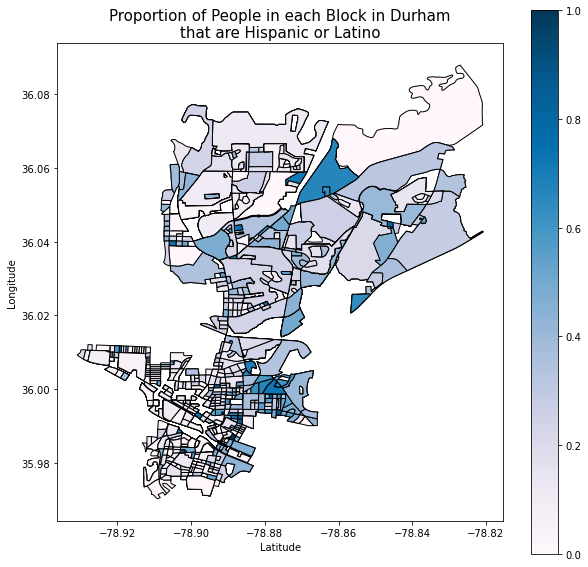

In [85]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
blockswithhispanics.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Block in Durham\nthat are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

start of checking how callcountperperson correlates with a beats popdensity

In [64]:
beatswithhispanics = pd.merge(cblockDurhamBeats, hispanicdata, left_on ='GEOID20', right_on='geoid20')
#beatswithhispanics = gpd.sjoin(cblockDurhamBeats, durhamhispanicmap)
popsumbybeat = beatswithhispanics.groupby('Beat', as_index=False).sum()
popsumbybeat

,Beat,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino
0,111,1885019,0,3949,1130,2819
1,112,1863048,0,3083,1366,1717
2,113,2056983,1025,4094,1038,3056
3,114,5975063,40919,5631,1756,3875
4,121,12440369,123268,8025,1803,6222
5,122,3167854,1644,3209,1478,1731
6,123,7274612,85253,9036,2629,6407
7,124,32035320,303409,14913,1106,13807
8,211,5952891,0,6544,965,5579
9,212,4111458,0,7901,1256,6645


In [71]:
popsumbybeat['total'].sum()


284780

In [65]:
policebeats_w_dpd = gpd.sjoin(policebeats, dpdcalls)
callssummedinbeats = policebeats_w_dpd.groupby(['LAWBEAT']).size().to_frame(name = 'calls_count').reset_index()
callssummedinbeats

,LAWBEAT,calls_count
0,111,2477
1,112,2334
2,113,2839
3,114,2805
4,121,2495
5,122,3070
6,123,2612
7,124,1827
8,211,3736
9,212,3167


In [66]:
policebeats_calls_w_callcount = pd.merge(policebeats_w_dpd, callssummedinbeats, left_on ='LAWBEAT', right_on='LAWBEAT')
policebeats_calls_w_callcount['area'] = policebeats_calls_w_callcount.area
policebeats_calls_w_callcount = policebeats_calls_w_callcount.groupby('LAWBEAT', as_index=False).mean()
policebeats_calls_w_callcount


,LAWBEAT,OBJECTID,PERIMETER,ShapeSTAre,ShapeSTLen,Beat_left,id,index_right,Event Numb,X,Y,Cancelled,calls_count,area
0,111,50.0,28608.800781,2.010252e+07,28608.799743,111.0,0.0,144556.454178,2.124067e+07,2.032488e+06,817873.029067,0.0,2477.0,0.000187
1,112,51.0,26265.849609,2.079934e+07,26265.852604,112.0,1.0,141814.763496,2.123627e+07,2.035512e+06,818871.362039,0.0,2334.0,0.000193
2,113,62.0,20667.539062,2.159195e+07,20667.538873,113.0,2.0,139624.402959,2.123224e+07,2.035223e+06,814263.195844,0.0,2839.0,0.000200
3,114,65.0,53321.980469,6.103382e+07,53321.974873,114.0,3.0,140596.262032,2.123422e+07,2.040281e+06,812064.585383,0.0,2805.0,0.000616
4,121,38.0,14495.120117,7.008533e+06,14495.120026,121.0,4.0,143320.079359,2.123890e+07,2.045828e+06,824005.007615,0.0,2495.0,0.001061
5,122,54.0,36686.679688,3.436298e+07,36686.681354,122.0,5.0,143562.447557,2.123929e+07,2.039433e+06,817595.542997,0.0,3070.0,0.000319
6,123,55.0,74375.859375,7.495698e+07,74375.856455,123.0,6.0,144876.994257,2.124150e+07,2.046093e+06,815364.300536,0.0,2612.0,0.000711
7,124,63.0,10708.070312,3.022588e+06,10708.070450,124.0,7.0,144959.805145,2.124171e+07,2.058114e+06,802758.864806,0.0,1827.0,0.002269
8,211,36.0,36748.878906,6.487864e+07,36748.875052,211.0,8.0,138694.192452,2.123069e+07,2.022369e+06,828201.705835,0.0,3736.0,0.000603
9,212,43.0,37127.789062,4.301152e+07,37127.786492,212.0,9.0,141527.279760,2.123573e+07,2.027481e+06,823625.628039,0.0,3167.0,0.000400


In [67]:
beats_callcount_popdata = pd.merge(policebeats_calls_w_callcount, popsumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_popdata['popdensity']= beats_callcount_popdata['total'] / beats_callcount_popdata['area']
beats_callcount_popdata['callcountperperson']= beats_callcount_popdata['calls_count'] / beats_callcount_popdata['total']
beats_callcount_popdata

,LAWBEAT,OBJECTID,PERIMETER,ShapeSTAre,ShapeSTLen,Beat_left,id,index_right,Event Numb,X,Y,Cancelled,calls_count,area,Beat,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino,popdensity,callcountperperson
0,111,50.0,28608.800781,2.010252e+07,28608.799743,111.0,0.0,144556.454178,2.124067e+07,2.032488e+06,817873.029067,0.0,2477.0,0.000187,111,1885019,0,3949,1130,2819,2.115229e+07,0.627247
1,112,51.0,26265.849609,2.079934e+07,26265.852604,112.0,1.0,141814.763496,2.123627e+07,2.035512e+06,818871.362039,0.0,2334.0,0.000193,112,1863048,0,3083,1366,1717,1.595999e+07,0.757055
2,113,62.0,20667.539062,2.159195e+07,20667.538873,113.0,2.0,139624.402959,2.123224e+07,2.035223e+06,814263.195844,0.0,2839.0,0.000200,113,2056983,1025,4094,1038,3056,2.041984e+07,0.693454
3,114,65.0,53321.980469,6.103382e+07,53321.974873,114.0,3.0,140596.262032,2.123422e+07,2.040281e+06,812064.585383,0.0,2805.0,0.000616,114,5975063,40919,5631,1756,3875,9.142323e+06,0.498135
4,121,38.0,14495.120117,7.008533e+06,14495.120026,121.0,4.0,143320.079359,2.123890e+07,2.045828e+06,824005.007615,0.0,2495.0,0.001061,121,12440369,123268,8025,1803,6222,7.560240e+06,0.310903
5,122,54.0,36686.679688,3.436298e+07,36686.681354,122.0,5.0,143562.447557,2.123929e+07,2.039433e+06,817595.542997,0.0,3070.0,0.000319,122,3167854,1644,3209,1478,1731,1.005581e+07,0.956684
6,123,55.0,74375.859375,7.495698e+07,74375.856455,123.0,6.0,144876.994257,2.124150e+07,2.046093e+06,815364.300536,0.0,2612.0,0.000711,123,7274612,85253,9036,2629,6407,1.271543e+07,0.289066
7,124,63.0,10708.070312,3.022588e+06,10708.070450,124.0,7.0,144959.805145,2.124171e+07,2.058114e+06,802758.864806,0.0,1827.0,0.002269,124,32035320,303409,14913,1106,13807,6.573608e+06,0.122511
8,211,36.0,36748.878906,6.487864e+07,36748.875052,211.0,8.0,138694.192452,2.123069e+07,2.022369e+06,828201.705835,0.0,3736.0,0.000603,211,5952891,0,6544,965,5579,1.085755e+07,0.570905
9,212,43.0,37127.789062,4.301152e+07,37127.786492,212.0,9.0,141527.279760,2.123573e+07,2.027481e+06,823625.628039,0.0,3167.0,0.000400,212,4111458,0,7901,1256,6645,1.977689e+07,0.400835


In [68]:
column_1 = beats_callcount_popdata["popdensity"]
column_2 = beats_callcount_popdata["callcountperperson"]
correlation = column_1.corr(column_2)
correlation

0.4885081680940668

In [73]:
#create a dataset for mapping
mappingdatasetforpolicebeats = pd.merge(policebeats, beats_callcount_popdata, on ='LAWBEAT')
mappingdatasetforpolicebeats

,LAWBEAT,geometry,OBJECTID_x,PERIMETER_x,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre_x,ShapeSTLen_x,Beat_x,id_x,OBJECTID_y,PERIMETER_y,ShapeSTAre_y,ShapeSTLen_y,Beat_left,id_y,index_right,Event Numb,X,Y,Cancelled,calls_count,area,Beat_y,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino,popdensity,callcountperperson
0,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,50.0,28608.800781,2.010252e+07,28608.799743,111.0,0.0,144556.454178,2.124067e+07,2.032488e+06,817873.029067,0.0,2477.0,0.000187,111,1885019,0,3949,1130,2819,2.115229e+07,0.627247
1,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1,51.0,26265.849609,2.079934e+07,26265.852604,112.0,1.0,141814.763496,2.123627e+07,2.035512e+06,818871.362039,0.0,2334.0,0.000193,112,1863048,0,3083,1366,1717,1.595999e+07,0.757055
2,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2,62.0,20667.539062,2.159195e+07,20667.538873,113.0,2.0,139624.402959,2.123224e+07,2.035223e+06,814263.195844,0.0,2839.0,0.000200,113,2056983,1025,4094,1038,3056,2.041984e+07,0.693454
3,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3,65.0,53321.980469,6.103382e+07,53321.974873,114.0,3.0,140596.262032,2.123422e+07,2.040281e+06,812064.585383,0.0,2805.0,0.000616,114,5975063,40919,5631,1756,3875,9.142323e+06,0.498135
4,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4,38.0,14495.120117,7.008533e+06,14495.120026,121.0,4.0,143320.079359,2.123890e+07,2.045828e+06,824005.007615,0.0,2495.0,0.001061,121,12440369,123268,8025,1803,6222,7.560240e+06,0.310903
5,122,"POLYGON ((-78.84694 36.00614, -78.84634 36.006...",54,36686.679688,I,yes,D1,122,None,3.436298e+07,36686.681354,122,5,54.0,36686.679688,3.436298e+07,36686.681354,122.0,5.0,143562.447557,2.123929e+07,2.039433e+06,817595.542997,0.0,3070.0,0.000319,122,3167854,1644,3209,1478,1731,1.005581e+07,0.956684
6,123,"MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...",55,74375.859375,I,yes,D1,123,None,7.495698e+07,74375.856455,123,6,55.0,74375.859375,7.495698e+07,74375.856455,123.0,6.0,144876.994257,2.124150e+07,2.046093e+06,815364.300536,0.0,2612.0,0.000711,123,7274612,85253,9036,2629,6407,1.271543e+07,0.289066
7,124,"MULTIPOLYGON (((-78.77636 35.92139, -78.77722 ...",63,10708.070312,I,no,D1,124,None,3.022588e+06,10708.070450,124,7,63.0,10708.070312,3.022588e+06,10708.070450,124.0,7.0,144959.805145,2.124171e+07,2.058114e+06,802758.864806,0.0,1827.0,0.002269,124,32035320,303409,14913,1106,13807,6.573608e+06,0.122511
8,211,"POLYGON ((-78.91430 36.04098, -78.91427 36.040...",36,36748.878906,I,yes,D2,211,None,6.487864e+07,36748.875052,211,8,36.0,36748.878906,6.487864e+07,36748.875052,211.0,8.0,138694.192452,2.123069e+07,2.022369e+06,828201.705835,0.0,3736.0,0.000603,211,5952891,0,6544,965,5579,1.085755e+07,0.570905
9,212,"POLYGON ((-78.90513 36.01904, -78.90330 36.019...",43,37127.789062,I,yes,D2,212,None,4.301152e+07,37127.786492,212,9,43.0,37127.789062,4.301152e+07,37127.786492,212.0,9.0,141527.279760,2.123573e+07,2.027481e+06,823625.628039,0.0,3167.0,0.000400,212,4111458,0,7901,1256,6645,1.977689e+07,0.400835


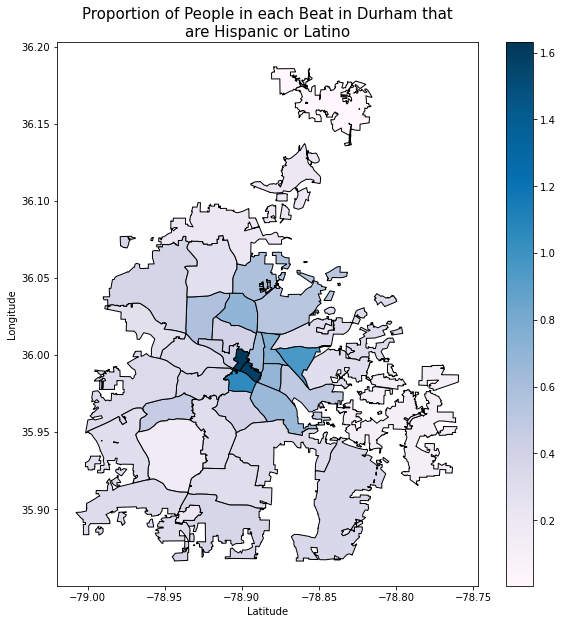

In [105]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats.plot(column='callcountperperson',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

end of checking how callcountperperson correlates with a beats popdensity

In [14]:
#putting race data into the police beat and block data
beatswithhispanics = gpd.sjoin(cblockDurhamBeats, durhamhispanicmap)
popsumbybeat = beatswithhispanics.groupby('Beat', as_index=False).sum()
hispanicsineachbeat = pd.merge(popsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
hispanicsineachbeat = hispanicsineachbeat.to_crs("EPSG:4326")
hispanicsineachbeat['prophispanic']= hispanicsineachbeat['total_hispanic_or_latino'] / hispanicsineachbeat['total']
hispanicsineachbeat

,Beat_x,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,Beat_y,id,prophispanic
0,111,17579442,0,32720,8601,24119,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,0.262867
1,112,17718915,0,27224,12345,14879,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1,0.453460
2,113,20482283,13325,35128,9451,25677,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2,0.269045
3,114,56673958,441791,53897,17371,36526,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3,0.322300
4,121,154087358,1453287,66559,16154,50405,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4,0.242702
5,122,34177498,14796,42111,17801,24310,122,"POLYGON ((-78.84694 36.00614, -78.84634 36.006...",54,36686.679688,I,yes,D1,122,None,3.436298e+07,36686.681354,122,5,0.422716
6,123,102491731,1285915,92956,30606,62350,123,"MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...",55,74375.859375,I,yes,D1,123,None,7.495698e+07,74375.856455,123,6,0.329253
7,124,427231134,2614325,145905,11424,134481,124,"MULTIPOLYGON (((-78.77636 35.92139, -78.77722 ...",63,10708.070312,I,no,D1,124,None,3.022588e+06,10708.070450,124,7,0.078298
8,211,57208452,0,64744,9599,55145,211,"POLYGON ((-78.91430 36.04098, -78.91427 36.040...",36,36748.878906,I,yes,D2,211,None,6.487864e+07,36748.875052,211,8,0.148261
9,212,38220261,0,107387,12111,95276,212,"POLYGON ((-78.90513 36.01904, -78.90330 36.019...",43,37127.789062,I,yes,D2,212,None,4.301152e+07,37127.786492,212,9,0.112779


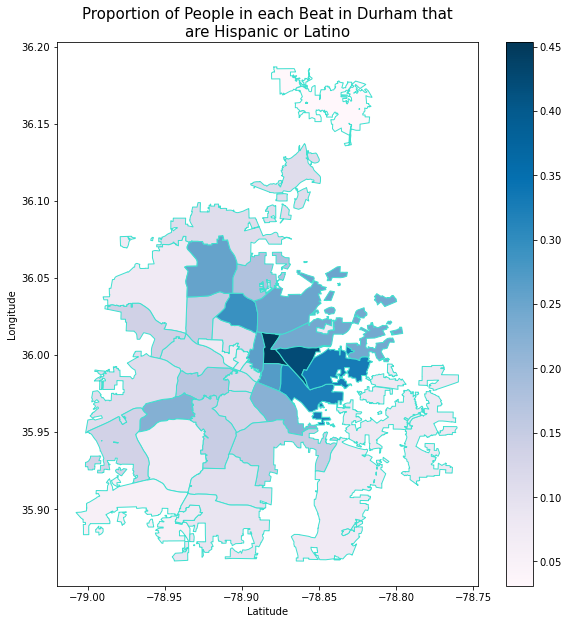

In [92]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
hispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'turquoise');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [83]:
commsafebeatswithhispanics = gpd.sjoin(cblockcommsafebeats, durhamhispanicmap)
commsafepopsumbybeat = commsafebeatswithhispanics.groupby('Beat', as_index=False).sum()
commsafehispanicsineachbeat = pd.merge(commsafepopsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
commsafehispanicsineachbeat = commsafehispanicsineachbeat.to_crs("EPSG:4326")
commsafehispanicsineachbeat['prophispanic']= commsafehispanicsineachbeat['total_hispanic_or_latino'] / commsafehispanicsineachbeat['total']

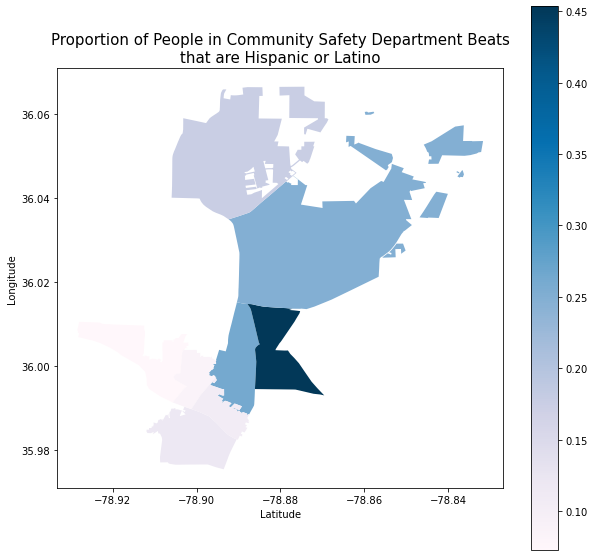

In [82]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
commsafehispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in Community Safety Department Beats\nthat are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

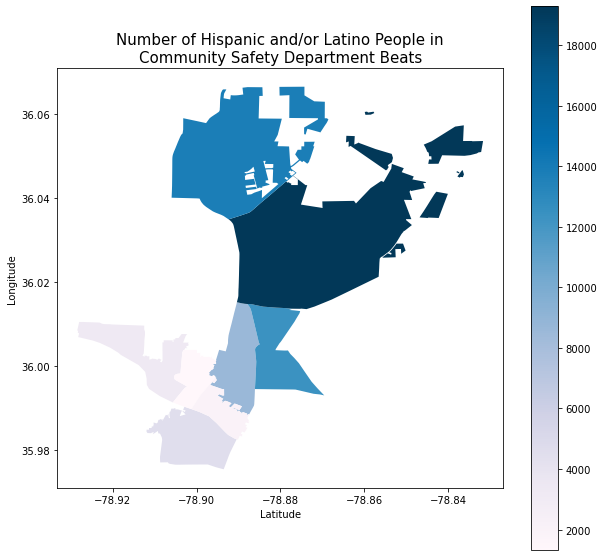

In [83]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
commsafehispanicsineachbeat.plot(column='total_hispanic_or_latino',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Number of Hispanic and/or Latino People in\nCommunity Safety Department Beats", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

commsafehispanicsineachbeat = hispanics by police beat but only including the beats that the community safety department is currently working in
hispanicsineachbeat = hispanics by police beat for all police beats in durham
blockswithhispanics = hispanics by census block but only the blocks in beats that the community safety department is currently working in

In [67]:
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
hispanicsinnoncommsafebeat = hispanicsineachbeat[~hispanicsineachbeat.Beat_x.isin(commsafe_list)]
hispanicsinnoncommsafebeat.head()

,Beat_x,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino,prophispanic,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,Beat_y,id
2,113,20482283,13325,35128,9451,25677,0.269045,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2
3,114,56673958,441791,53897,17371,36526,0.322300,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3
4,121,154087358,1453287,66559,16154,50405,0.242702,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4
5,122,34177498,14796,42111,17801,24310,0.422716,122,"POLYGON ((-78.84694 36.00614, -78.84634 36.006...",54,36686.679688,I,yes,D1,122,None,3.436298e+07,36686.681354,122,5
6,123,102491731,1285915,92956,30606,62350,0.329253,123,"MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...",55,74375.859375,I,yes,D1,123,None,7.495698e+07,74375.856455,123,6


In [69]:
meanpropofhispanicsnotincommsafe = hispanicsinnoncommsafebeat[["prophispanic"]].mean()
meanpropofhispanicsnotincommsafe

prophispanic    0.16163
dtype: float64

In [46]:
meanpropofhispanicsincommsafe = commsafehispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsincommsafe

prophispanic    0.190683
dtype: float64

In [47]:
meanpropofhispanicsinallbeats = hispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsinallbeats

prophispanic    0.167912
dtype: float64

start looking at pop data change by block oer past 10 years

In [84]:
hispanicdata2010 = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/hispanicdata2010/hispanicdata2010.csv', skiprows =1)
hispanicdata2010['GEOID20'] = hispanicdata2010['id'].str[-15:]
hispanicdata2010.drop('id', axis=1, inplace=True)
hispanicdata2010.drop(hispanicdata2010.iloc[:, 0:25], inplace = True, axis = 1)
hispanicdata2010.drop(hispanicdata2010.iloc[:, 1:48], inplace = True, axis = 1)
#hispanicdata2010.columns = hispanicdata2010.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata2010.rename(columns = {'Total':'total2010'}, inplace = True)
hispanicdata2010

,total2010,Geographic Area Name,GEOID20
0,97,"Block 1000, Block Group 1, Census Tract 1.01, ...",370630001011000
1,51,"Block 1001, Block Group 1, Census Tract 1.01, ...",370630001011001
2,38,"Block 1002, Block Group 1, Census Tract 1.01, ...",370630001011002
3,47,"Block 1003, Block Group 1, Census Tract 1.01, ...",370630001011003
4,51,"Block 1004, Block Group 1, Census Tract 1.01, ...",370630001011004
...,...,...,...
5024,0,"Block 1124, Block Group 1, Census Tract 9801, ...",370639801001124
5025,0,"Block 1125, Block Group 1, Census Tract 9801, ...",370639801001125
5026,0,"Block 1126, Block Group 1, Census Tract 9801, ...",370639801001126
5027,0,"Block 1127, Block Group 1, Census Tract 9801, ...",370639801001127


In [85]:
hispanicpopforbothyears = pd.merge(hispanicdata2010, hispanicdata, left_on='GEOID20', right_on='geoid20')
hispanicpopforbothyears['total2010'] = hispanicpopforbothyears['total2010'].astype(int)
hispanicpopforbothyears['percentpopgrowth']= hispanicpopforbothyears['total'] / hispanicpopforbothyears['total2010']
hispanicpopforbothyears

,total2010,Geographic Area Name,GEOID20,geographic_area_name,total,total_hispanic_or_latino,total_not_hispanic_or_latino,geoid20,percentpopgrowth
0,97,"Block 1000, Block Group 1, Census Tract 1.01, ...",370630001011000,"Block 1000, Block Group 1, Census Tract 1.01, ...",108,25,83,370630001011000,1.113402
1,51,"Block 1001, Block Group 1, Census Tract 1.01, ...",370630001011001,"Block 1001, Block Group 1, Census Tract 1.01, ...",35,12,23,370630001011001,0.686275
2,38,"Block 1002, Block Group 1, Census Tract 1.01, ...",370630001011002,"Block 1002, Block Group 1, Census Tract 1.01, ...",38,8,30,370630001011002,1.000000
3,47,"Block 1003, Block Group 1, Census Tract 1.01, ...",370630001011003,"Block 1003, Block Group 1, Census Tract 1.01, ...",43,0,43,370630001011003,0.914894
4,51,"Block 1004, Block Group 1, Census Tract 1.01, ...",370630001011004,"Block 1004, Block Group 1, Census Tract 1.01, ...",31,7,24,370630001011004,0.607843
...,...,...,...,...,...,...,...,...,...
2249,0,"Block 1068, Block Group 1, Census Tract 9801, ...",370639801001068,"Block 1068, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001068,NaN
2250,0,"Block 1069, Block Group 1, Census Tract 9801, ...",370639801001069,"Block 1069, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001069,NaN
2251,0,"Block 1070, Block Group 1, Census Tract 9801, ...",370639801001070,"Block 1070, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001070,NaN
2252,0,"Block 1071, Block Group 1, Census Tract 9801, ...",370639801001071,"Block 1071, Block Group 1, Census Tract 9801, ...",0,0,0,370639801001071,NaN


In [125]:
hispanicpopforbothyears.columns

Index(['total2010', 'Geographic Area Name', 'GEOID20', 'geographic_area_name',
       'total', 'total_hispanic_or_latino', 'total_not_hispanic_or_latino',
       'geoid20', 'percentpopgrowth'],
      dtype='object')

In [86]:
percentgrowth = hispanicpopforbothyears[['GEOID20','percentpopgrowth']]
percentgrowth.head()

,GEOID20,percentpopgrowth
0,370630001011000,1.113402
1,370630001011001,0.686275
2,370630001011002,1.000000
3,370630001011003,0.914894
4,370630001011004,0.607843


start looking at age

In [120]:
sexbyagedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/sexbyagedata/sexbyage.csv', skiprows =1)
sexbyagedata['GEOID20'] = sexbyagedata['id'].str[-15:]
sexbyagedata.drop('id', axis=1, inplace=True)
sexbyagedata.rename(columns = {'Total':'popcount2010'}, inplace = True)
sexbyagedata.rename(columns = {'Total!!Male':'popcountmale'}, inplace = True)
sexbyagedata.rename(columns = {'Total!!Female':'popcountfemale'}, inplace = True)
sexbyagedata.columns = sexbyagedata.columns.str.lstrip('Total!!Male!!')
sexbyagedata.columns = sexbyagedata.columns.str.lstrip('Total!!Female!!')
sexbyagedata

,popcount2010,popcountmale,Under 5 years,5 to 9 years,10 to 14 years,15 to 17 years,18 and 19 years,20 years,21 years,22 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over,popcountfemale,Under 5 years,5 to 9 years,10 to 14 years,15 to 17 years,18 and 19 years,20 years,21 years,22 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over,Geographic Area Name,GEOID20
0,97,54,8,2,3,2,4,2,1,0,7,8,2,3,5,2,2,0,0,1,1,1,0,0,0,43,1,4,4,0,2,0,1,2,1,2,5,2,3,4,5,1,0,0,4,0,1,1,0,"Block 1000, Block Group 1, Census Tract 1.01, ...",370630001011000
1,51,24,1,3,2,2,0,0,0,0,3,3,1,2,1,3,1,0,0,0,0,1,1,0,0,27,0,6,2,0,0,0,0,0,3,2,3,3,1,1,1,0,1,0,1,0,2,0,1,"Block 1001, Block Group 1, Census Tract 1.01, ...",370630001011001
2,38,23,3,1,2,0,0,0,0,0,2,4,5,2,0,0,3,0,1,0,0,0,0,0,0,15,0,2,0,1,0,0,0,0,2,5,1,0,1,1,1,1,0,0,0,0,0,0,0,"Block 1002, Block Group 1, Census Tract 1.01, ...",370630001011002
3,47,30,3,4,4,3,3,0,1,1,2,3,2,2,1,0,0,0,0,1,0,0,0,0,0,17,1,2,2,1,0,1,0,0,1,1,4,1,0,1,2,0,0,0,0,0,0,0,0,"Block 1003, Block Group 1, Census Tract 1.01, ...",370630001011003
4,51,29,0,2,1,0,1,2,1,4,4,1,3,3,2,1,2,0,0,0,0,0,1,1,0,22,2,2,0,1,0,0,0,2,2,1,1,4,2,2,1,0,0,0,0,0,2,0,0,"Block 1004, Block Group 1, Census Tract 1.01, ...",370630001011004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Block 1124, Block Group 1, Census Tract 9801, ...",370639801001124
5025,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Block 1125, Block Group 1, Census Tract 9801, ...",370639801001125
5026,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Block 1126, Block Group 1, Census Tract 9801, ...",370639801001126
5027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Block 1127, Block Group 1, Census Tract 9801, ...",370639801001127


In [121]:
#Add duplicate column names together
sexbyagedata = sexbyagedata.sum(axis=1, level=0, skipna=False)
sexbyagedata["GEOID20"] = sexbyagedata["GEOID20"].map(str)
sexbyagedata['GEOID20'] = sexbyagedata['GEOID20'].str[:-2]

In [122]:
#Merge sexbyage with percentgrowth on geoid
sexbyage2020 = pd.merge(percentgrowth, sexbyagedata, on = 'GEOID20')

In [123]:
cols_s = sexbyage2020.columns[sexbyage2020.columns.str.endswith('s')]

for col_s in cols_s:
        sexbyage2020['2020 ' + col_s] = sexbyage2020['percentpopgrowth'] * sexbyage2020[col_s]

sexbyage2020['popcount2010'] = sexbyage2020['popcount2010'].astype(float)
sexbyage2020['popcount2020'] = sexbyage2020['popcount2010'] * sexbyage2020['percentpopgrowth']
sexbyage2020.head(1)


,GEOID20,percentpopgrowth,popcount2010,popcountmale,Under 5 years,5 to 9 years,10 to 14 years,15 to 17 years,18 and 19 years,20 years,21 years,22 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over,popcountfemale,Geographic Area Name,2020 Under 5 years,2020 5 to 9 years,2020 10 to 14 years,2020 15 to 17 years,2020 18 and 19 years,2020 20 years,2020 21 years,2020 22 to 24 years,2020 25 to 29 years,2020 30 to 34 years,2020 35 to 39 years,2020 40 to 44 years,2020 45 to 49 years,2020 50 to 54 years,2020 55 to 59 years,2020 60 and 61 years,2020 62 to 64 years,2020 65 and 66 years,2020 67 to 69 years,2020 70 to 74 years,2020 75 to 79 years,2020 80 to 84 years,popcount2020
0,370630001011000,1.113402,97.0,54,9,6,7,2,6,2,2,2,8,10,7,5,8,6,7,1,0,1,5,1,1,1,0,43,"Block 1000, Block Group 1, Census Tract 1.01, ...",10.020619,6.680412,7.793814,2.226804,6.680412,2.226804,2.226804,2.226804,8.907216,11.134021,7.793814,5.56701,8.907216,6.680412,7.793814,1.113402,0.0,1.113402,5.56701,1.113402,1.113402,1.113402,108.0


In [124]:
sexbyage2020.drop(sexbyage2020.iloc[:, 3:28], inplace = True, axis = 1)
sexbyage2020.head(1)

,GEOID20,percentpopgrowth,popcount2010,Geographic Area Name,2020 Under 5 years,2020 5 to 9 years,2020 10 to 14 years,2020 15 to 17 years,2020 18 and 19 years,2020 20 years,2020 21 years,2020 22 to 24 years,2020 25 to 29 years,2020 30 to 34 years,2020 35 to 39 years,2020 40 to 44 years,2020 45 to 49 years,2020 50 to 54 years,2020 55 to 59 years,2020 60 and 61 years,2020 62 to 64 years,2020 65 and 66 years,2020 67 to 69 years,2020 70 to 74 years,2020 75 to 79 years,2020 80 to 84 years,popcount2020
0,370630001011000,1.113402,97.0,"Block 1000, Block Group 1, Census Tract 1.01, ...",10.020619,6.680412,7.793814,2.226804,6.680412,2.226804,2.226804,2.226804,8.907216,11.134021,7.793814,5.56701,8.907216,6.680412,7.793814,1.113402,0.0,1.113402,5.56701,1.113402,1.113402,1.113402,108.0


In [125]:
sexbyage2020['14 years and under'] = sexbyage2020['2020 Under 5 years'] + sexbyage2020['2020 5 to 9 years'] + sexbyage2020['2020 10 to 14 years'] + sexbyage2020['2020 15 to 17 years']
sexbyage2020['15 to 24 years'] = sexbyage2020['2020 15 to 17 years'] + sexbyage2020['2020 18 and 19 years'] + sexbyage2020['2020 20 years'] + sexbyage2020['2020 21 years'] + sexbyage2020['2020 22 to 24 years']
sexbyage2020['25 to 64 years'] = sexbyage2020['2020 25 to 29 years'] + sexbyage2020['2020 30 to 34 years'] + sexbyage2020['2020 35 to 39 years'] + sexbyage2020['2020 40 to 44 years'] + sexbyage2020['2020 45 to 49 years'] + sexbyage2020['2020 50 to 54 years'] + sexbyage2020['2020 55 to 59 years'] + sexbyage2020['2020 60 and 61 years'] + sexbyage2020['2020 62 to 64 years']
sexbyage2020['65 years and over'] = sexbyage2020['2020 65 and 66 years'] + sexbyage2020['2020 67 to 69 years'] + sexbyage2020['2020 70 to 74 years'] + sexbyage2020['2020 75 to 79 years'] + sexbyage2020['2020 80 to 84 years']
sexbyage2020.head(1)


,GEOID20,percentpopgrowth,popcount2010,Geographic Area Name,2020 Under 5 years,2020 5 to 9 years,2020 10 to 14 years,2020 15 to 17 years,2020 18 and 19 years,2020 20 years,2020 21 years,2020 22 to 24 years,2020 25 to 29 years,2020 30 to 34 years,2020 35 to 39 years,2020 40 to 44 years,2020 45 to 49 years,2020 50 to 54 years,2020 55 to 59 years,2020 60 and 61 years,2020 62 to 64 years,2020 65 and 66 years,2020 67 to 69 years,2020 70 to 74 years,2020 75 to 79 years,2020 80 to 84 years,popcount2020,14 years and under,15 to 24 years,25 to 64 years,65 years and over
0,370630001011000,1.113402,97.0,"Block 1000, Block Group 1, Census Tract 1.01, ...",10.020619,6.680412,7.793814,2.226804,6.680412,2.226804,2.226804,2.226804,8.907216,11.134021,7.793814,5.56701,8.907216,6.680412,7.793814,1.113402,0.0,1.113402,5.56701,1.113402,1.113402,1.113402,108.0,26.721649,15.587629,57.896907,10.020619


In [126]:
sexbyage2020.drop(sexbyage2020.iloc[:, 2:26], inplace = True, axis = 1)
sexbyage2020

,GEOID20,percentpopgrowth,popcount2020,14 years and under,15 to 24 years,25 to 64 years,65 years and over
0,370630001011000,1.113402,108.0,26.721649,15.587629,57.896907,10.020619
1,370630001011001,0.686275,35.0,10.980392,1.372549,19.901961,3.431373
2,370630001011002,1.000000,38.0,9.000000,1.000000,29.000000,0.000000
3,370630001011003,0.914894,43.0,18.297872,9.148936,18.297872,0.914894
4,370630001011004,0.607843,31.0,4.862745,6.686275,17.627451,2.431373
...,...,...,...,...,...,...,...
2249,370639801001068,NaN,NaN,NaN,NaN,NaN,NaN
2250,370639801001069,NaN,NaN,NaN,NaN,NaN,NaN
2251,370639801001070,NaN,NaN,NaN,NaN,NaN,NaN
2252,370639801001071,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
durhamagemap = pd.merge(sexbyage2020, durhamblockmap, left_on ='GEOID20', right_on='GEOID20')
durhamagemap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamagemap['propadults']= durhamagemap['25 to 64 years'] / durhamagemap['popcount2020']
durhamagemap['propyouth']= durhamagemap['15 to 24 years'] / durhamagemap['popcount2020']
durhamagemap['propchildren']= durhamagemap['14 years and under'] / durhamagemap['popcount2020']
durhamagemap['propseniors']= durhamagemap['65 years and over'] / durhamagemap['popcount2020']
durhamagemap

,GEOID20,percentpopgrowth,popcount2020,14 years and under,15 to 24 years,25 to 64 years,65 years and over,COUNTYFP20,INTPTLAT20,INTPTLON20,geometry,propadults,propyouth,propchildren,propseniors
0,370630001011000,1.113402,108.0,26.721649,15.587629,57.896907,10.020619,063,+36.0194814,-078.8821382,"POLYGON ((-78.88998 36.01852, -78.88995 36.019...",0.536082,0.144330,0.247423,0.092784
1,370630001011001,0.686275,35.0,10.980392,1.372549,19.901961,3.431373,063,+36.0205516,-078.8893121,"POLYGON ((-78.88993 36.02006, -78.88990 36.021...",0.568627,0.039216,0.313725,0.098039
2,370630001011002,1.000000,38.0,9.000000,1.000000,29.000000,0.000000,063,+36.0205916,-078.8869754,"POLYGON ((-78.88749 36.02015, -78.88746 36.021...",0.763158,0.026316,0.236842,0.000000
3,370630001011003,0.914894,43.0,18.297872,9.148936,18.297872,0.914894,063,+36.0205318,-078.8880959,"POLYGON ((-78.88872 36.01988, -78.88867 36.021...",0.425532,0.212766,0.425532,0.021277
4,370630001011004,0.607843,31.0,4.862745,6.686275,17.627451,2.431373,063,+36.0221289,-078.8796703,"POLYGON ((-78.88098 36.02211, -78.87992 36.022...",0.568627,0.215686,0.156863,0.078431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,370639801001068,NaN,NaN,NaN,NaN,NaN,NaN,063,+35.8697575,-078.8648679,"POLYGON ((-78.86527 35.87075, -78.86498 35.870...",NaN,NaN,NaN,NaN
2250,370639801001069,NaN,NaN,NaN,NaN,NaN,NaN,063,+35.8691012,-078.8652956,"POLYGON ((-78.86568 35.87061, -78.86540 35.870...",NaN,NaN,NaN,NaN
2251,370639801001070,NaN,NaN,NaN,NaN,NaN,NaN,063,+35.8687255,-078.8673419,"POLYGON ((-78.87003 35.86799, -78.86977 35.868...",NaN,NaN,NaN,NaN
2252,370639801001071,NaN,NaN,NaN,NaN,NaN,NaN,063,+35.8957583,-078.8703320,"POLYGON ((-78.87243 35.89600, -78.87216 35.896...",NaN,NaN,NaN,NaN


In [96]:
meanadultprop = durhamagemap[["propadults"]].mean()
meanadultprop

propadults    0.580112
dtype: float64

In [244]:
meanyouthprop = durhamagemap[["propyouth"]].mean()
meanyouthprop

propyouth    0.118449
dtype: float64

In [245]:
meanchildrenprop = durhamagemap[["propchildren"]].mean()
meanchildrenprop

propchildren    0.213303
dtype: float64

In [246]:
meanseniorprop = durhamagemap[["propseniors"]].mean()
meanseniorprop

propseniors    0.10571
dtype: float64

start of checking how callcountperperson correlates with proportioon of people that are "youth"

In [127]:
agedataindurhambyblocks = pd.merge(cblockDurhamBeats, sexbyage2020, left_on ='GEOID20', right_on='GEOID20')
agesumbybeat = agedataindurhambyblocks.groupby('Beat', as_index=False).sum()
agesumbybeat

,Beat,ALAND20,AWATER20,percentpopgrowth,popcount2020,14 years and under,15 to 24 years,25 to 64 years,65 years and over
0,111,1439855,0,NaN,2113.0,534.068696,287.595933,1193.204456,151.277395
1,112,1863048,0,NaN,2346.0,621.527576,459.513046,1230.647240,137.395283
2,113,1554678,1025,NaN,3177.0,873.984535,413.447871,1762.000613,216.780666
3,114,3675145,36473,NaN,2208.0,568.203855,288.853978,1170.169511,250.296900
4,121,7026570,84836,NaN,2892.0,810.078622,300.629947,1629.930644,254.881400
5,122,1247333,0,NaN,1588.0,596.224142,230.349782,788.898539,62.021748
6,123,3028996,14258,NaN,3332.0,788.787574,625.835747,1505.576561,615.343267
7,124,10281982,203889,NaN,3161.0,634.344918,246.749104,1941.288928,406.202292
8,211,4855609,0,NaN,4265.0,806.473651,431.116826,2666.864362,397.285798
9,212,3943031,0,NaN,6541.0,1234.112848,752.260833,4177.594981,425.288119


In [129]:
beats_callcount_agedata = pd.merge(policebeats_calls_w_callcount, agesumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_agedata['callcountperperson']= beats_callcount_agedata['calls_count'] / beats_callcount_agedata['popcount2020']
beats_callcount_agedata['propyouth']= beats_callcount_agedata['15 to 24 years'] / beats_callcount_agedata['popcount2020']
beats_callcount_agedata

,LAWBEAT,OBJECTID,PERIMETER,ShapeSTAre,ShapeSTLen,Beat_left,id,index_right,Event Numb,X,Y,Cancelled,calls_count,area,Beat,ALAND20,AWATER20,percentpopgrowth,popcount2020,14 years and under,15 to 24 years,25 to 64 years,65 years and over,callcountperperson,propyouth
0,111,50.0,28608.800781,2.010252e+07,28608.799743,111.0,0.0,144556.454178,2.124067e+07,2.032488e+06,817873.029067,0.0,2477.0,0.000187,111,1439855,0,NaN,2113.0,534.068696,287.595933,1193.204456,151.277395,1.172267,0.136108
1,112,51.0,26265.849609,2.079934e+07,26265.852604,112.0,1.0,141814.763496,2.123627e+07,2.035512e+06,818871.362039,0.0,2334.0,0.000193,112,1863048,0,NaN,2346.0,621.527576,459.513046,1230.647240,137.395283,0.994885,0.195871
2,113,62.0,20667.539062,2.159195e+07,20667.538873,113.0,2.0,139624.402959,2.123224e+07,2.035223e+06,814263.195844,0.0,2839.0,0.000200,113,1554678,1025,NaN,3177.0,873.984535,413.447871,1762.000613,216.780666,0.893610,0.130138
3,114,65.0,53321.980469,6.103382e+07,53321.974873,114.0,3.0,140596.262032,2.123422e+07,2.040281e+06,812064.585383,0.0,2805.0,0.000616,114,3675145,36473,NaN,2208.0,568.203855,288.853978,1170.169511,250.296900,1.270380,0.130822
4,121,38.0,14495.120117,7.008533e+06,14495.120026,121.0,4.0,143320.079359,2.123890e+07,2.045828e+06,824005.007615,0.0,2495.0,0.001061,121,7026570,84836,NaN,2892.0,810.078622,300.629947,1629.930644,254.881400,0.862725,0.103952
5,122,54.0,36686.679688,3.436298e+07,36686.681354,122.0,5.0,143562.447557,2.123929e+07,2.039433e+06,817595.542997,0.0,3070.0,0.000319,122,1247333,0,NaN,1588.0,596.224142,230.349782,788.898539,62.021748,1.933249,0.145057
6,123,55.0,74375.859375,7.495698e+07,74375.856455,123.0,6.0,144876.994257,2.124150e+07,2.046093e+06,815364.300536,0.0,2612.0,0.000711,123,3028996,14258,NaN,3332.0,788.787574,625.835747,1505.576561,615.343267,0.783914,0.187826
7,124,63.0,10708.070312,3.022588e+06,10708.070450,124.0,7.0,144959.805145,2.124171e+07,2.058114e+06,802758.864806,0.0,1827.0,0.002269,124,10281982,203889,NaN,3161.0,634.344918,246.749104,1941.288928,406.202292,0.577982,0.078060
8,211,36.0,36748.878906,6.487864e+07,36748.875052,211.0,8.0,138694.192452,2.123069e+07,2.022369e+06,828201.705835,0.0,3736.0,0.000603,211,4855609,0,NaN,4265.0,806.473651,431.116826,2666.864362,397.285798,0.875967,0.101082
9,212,43.0,37127.789062,4.301152e+07,37127.786492,212.0,9.0,141527.279760,2.123573e+07,2.027481e+06,823625.628039,0.0,3167.0,0.000400,212,3943031,0,NaN,6541.0,1234.112848,752.260833,4177.594981,425.288119,0.484177,0.115007


In [131]:
column_1 = beats_callcount_agedata["propyouth"]
column_2 = beats_callcount_agedata["callcountperperson"]
correlation = column_1.corr(column_2)
correlation

-0.1381195762793613

end of checking how callcountperperson correlates with proportioon of people that are "youth"

In [102]:
callswithblock = gpd.sjoin(hispanicsineachbeat, dpdcalls)
callswithblock

,Beat_x,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,Beat_y,id,prophispanic,index_right,Event Numb,Case Numbe,Call Date,Call Time,Source,Priority,Nature,Address,X,Y,District,Beat,Dispositio,Cancelled
0,111,17579442,0,32720,8601,24119,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,0.262867,177530,21293655,None,8/14/2021,1:32:59AM,Wireless 911 Call,3,SUSPICIOUS PERSON,700 EVA ST,2032833,816481,D1,111,Resolved Without Report,0
0,111,17579442,0,32720,8601,24119,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,0.262867,81402,21130431,None,4/16/2021,10:28:57PM,Phone Call,4,ABANDONED VEHICLE,700 LIBERTY ST,2032653,816485,D1,111,Unfounded,0
0,111,17579442,0,32720,8601,24119,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,0.262867,162382,21266555,None,7/25/2021,2:56:55PM,Wireless 911 Call,4,DAMAGE TO PROPERTY,700 LIBERTY ST,2032638,816487,D1,111,Resolved Without Report,0
0,111,17579442,0,32720,8601,24119,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,0.262867,249209,21425792,21040163,11/21/2021,8:24:18PM,Wireless 911 Call,3,RUNAWAY,700 LIBERTY ST,2032680,816488,D1,111,Incident Report,0
0,111,17579442,0,32720,8601,24119,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,0.262867,122841,21198887,None,6/7/2021,9:31:08PM,Phone Call,4,NOISE COMPLAINT,EVA ST/RAILROAD ST,2032540,816526,D1,111,Unfounded,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,999,15400563,125985,9616,715,8901,999,"MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...",4,1308.963013,None,None,DSO,DSO,None,6.932677e+04,1308.962953,999,36,0.074355,209464,21352435,None,9/26/2021,6:29:32PM,Wireless 911 Call,2,UNKNOWN PROBLEM POLICE,3600 WIGGINS ST,2034206,833636,D2,223,Resolved Without Report,0
36,999,15400563,125985,9616,715,8901,999,"MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...",4,1308.963013,None,None,DSO,DSO,None,6.932677e+04,1308.962953,999,36,0.074355,49642,21079101,None,3/7/2021,6:45:41PM,{Other},3,SOUND OF SHOTS,3600 WIGGINS ST,2034170,833636,D2,223,Unfounded,0
36,999,15400563,125985,9616,715,8901,999,"MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...",4,1308.963013,None,None,DSO,DSO,None,6.932677e+04,1308.962953,999,36,0.074355,112677,21181875,None,5/26/2021,3:20:07PM,Phone Call,3,TRAFFIC HAZARD,BARBEE RD/HERNDON RD,2021358,783360,D4,422,Resolved Without Report,0
36,999,15400563,125985,9616,715,8901,999,"MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...",4,1308.963013,None,None,DSO,DSO,None,6.932677e+04,1308.962953,999,36,0.074355,67540,21107612,None,3/30/2021,4:56:13PM,Phone Call,4,FOLLOW UP,BARBEE RD/HERNDON RD,2021339,783370,D4,422,Resolved Without Report,0


In [99]:
callswithblock['callsperperson']= callswithblock['15 to 24 years'] / callswithblock['popcount2020']
callswithblock.head(1)


KeyError: '15 to 24 years'

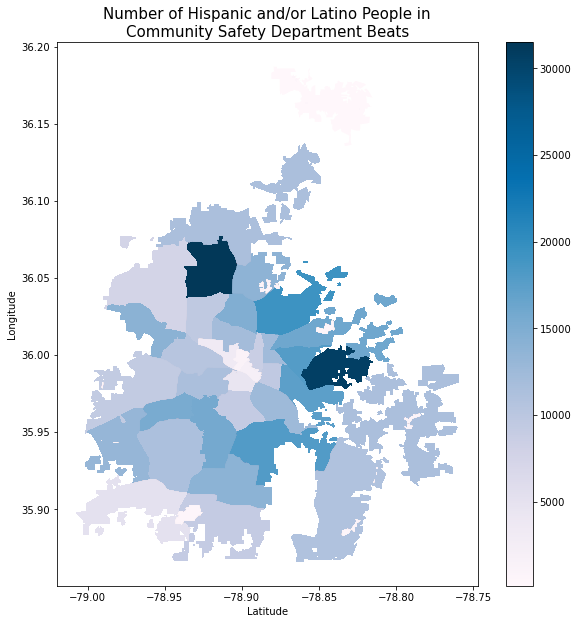

In [103]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
callswithblock.plot(column='total_hispanic_or_latino',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Number of Hispanic and/or Latino People in\nCommunity Safety Department Beats", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [4]:
nonhomelessdata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/nonhomelesspopulatiodata/nonhomelessdata.csv', skiprows =1)
nonhomelessdata['GEOID20'] = nonhomelessdata['id'].str[-15:]
nonhomelessdata.drop('id', axis=1, inplace=True)
#sexbyagedata.rename(columns = {'Total':'popcount2010'}, inplace = True)
#sexbyagedata.columns = sexbyagedata.columns.str.lstrip('Total!!Male!!')
nonhomelessdata

,Total,Total!!Under 18 years,Total!!18 years and over,Geographic Area Name,GEOID20
0,93,24,69,"Block 1000, Block Group 1, Census Tract 1.01, ...",370630001011000
1,51,16,35,"Block 1001, Block Group 1, Census Tract 1.01, ...",370630001011001
2,38,9,29,"Block 1002, Block Group 1, Census Tract 1.01, ...",370630001011002
3,47,20,27,"Block 1003, Block Group 1, Census Tract 1.01, ...",370630001011003
4,51,8,43,"Block 1004, Block Group 1, Census Tract 1.01, ...",370630001011004
...,...,...,...,...,...
5024,0,0,0,"Block 1124, Block Group 1, Census Tract 9801, ...",370639801001124
5025,0,0,0,"Block 1125, Block Group 1, Census Tract 9801, ...",370639801001125
5026,0,0,0,"Block 1126, Block Group 1, Census Tract 9801, ...",370639801001126
5027,0,0,0,"Block 1127, Block Group 1, Census Tract 9801, ...",370639801001127
